**Домашнее задание**

Реализуйте один или несколько критериев останова: минимальное количество объектов в листе (min_leaf), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции build_tree и проверьте ее работоспособность с помощью визуализации дерева (функция print_tree).

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [143]:
# Сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=142)
# classification_data, classification_labels = make_circles(n_samples=30, random_state=5)

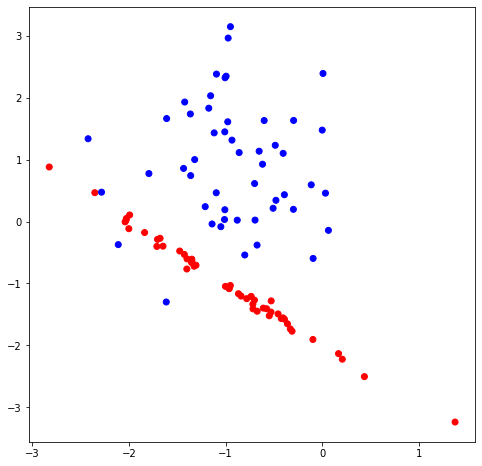

In [144]:
# Визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

Критерии останова - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

Ограничение максимальной глубины дерева.

Ограничение максимального количества листьев.

Ограничение минимального количества  𝑛  объектов в листе.

Останов в случае, когда все объекты в листе относятся к одному классу.

Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

In [145]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # Индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # Значение порога
        self.true_branch = true_branch  # Поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # Поддерево, не удовлетворяющее условию в узле

In [146]:
# Реализуем класс листа
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # Подсчёт количества объектов разных классов
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # Найдём класс, количество объектов которого будет максимальным в этом листе и вернём его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [147]:
# Расчёт критерия Джини
def gini(labels):
    # Подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    # Расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [148]:
# Расчёт прироста
def gain(left_labels, right_labels, root_gini):

    # Доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [149]:
# Разбиение датасета в узле
def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [150]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels, min_samples_leaf):
    
    # Обозначим минимальное количество объектов в узле
    # min_samples_leaf = 3

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # Будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            # Пропускаем разбиения, в которых в узле остаётся менее min_samples_leaf объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            # Выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [151]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, min_samples_leaf, max_depth, depth=0):   # добавил min_samples_leaf

    gain, t, index = find_best_split(data, labels, min_samples_leaf)

    # Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
      return Leaf(data, labels)

    # Останов по глубине дерева
    if max_depth <= depth:
      return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_samples_leaf, max_depth, depth + 1)

    # print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, min_samples_leaf, max_depth, depth + 1)
    
    # print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть класс целого дерева
    return Node(index, t, true_branch, false_branch)

In [152]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [153]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [154]:
# Разобьём выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [155]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_leaf=5, max_depth=3) # добавил аргумент min_samples_leaf (минимальное количество объектов в листе)

In [156]:
# Напечатаем ход дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсивный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсивный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= 0.10637080118918174
--> True:
  Индекс 1 <= -0.6023570601621359
  --> True:
    Индекс 0 <= -1.326867561665578
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0 <= -1.4751871310035263
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
--> False:
  Индекс 0 <= -1.423723265960491
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 1


In [157]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [158]:
# Получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [159]:
# Введём функцию подсчёта точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [160]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

95.71428571428572

In [161]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

93.33333333333333

In [162]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # График обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # График тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

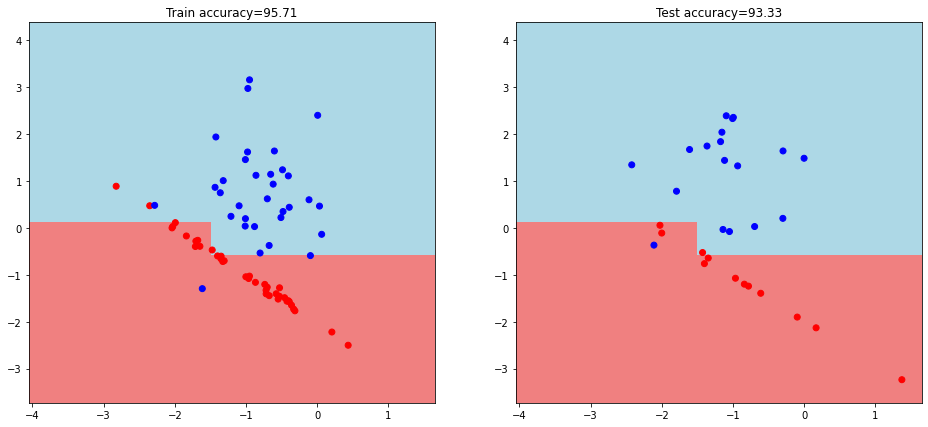

In [163]:
visualize(train_data, test_data)